In [1]:
import arrow
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from salishsea_tools import rivertools, nc_tools, viz_tools
from salishsea_tools import river_202101 as rivers

prop_dict_name ='river_202101'

%matplotlib inline

In [2]:
# what coordinates are you using?
gridcoords = 'coordinates_seagrid_SalishSea201702.nc'
coords_file = '../../../grid/'+gridcoords
# where is the river information? 
prop_dict = rivers.prop_dict

In [3]:
#get dimensions for netcdf files
fB = xr.open_dataset(coords_file, decode_times=False)
lat = fB['nav_lat'][:]
lon = fB['nav_lon'][:]
e1t = fB['e1t'][0,:]
e2t = fB['e2t'][0,:]
horz_area = e1t*e2t
fB.close()

In [4]:
#list of watersheds we are including
names = ['bute', 'evi_n', 'jervis', 'evi_s', 'howe', 'jdf', 'skagit', 'puget', 'toba', 'fraser']

In [5]:
# Constant and data ranges etc
year = 2016
smonth = 1
emonth = 12
startdate = arrow.get(year, smonth, 1)
enddate = arrow.get(year, emonth, 31)
print (startdate, enddate)

2016-01-01T00:00:00+00:00 2016-12-31T00:00:00+00:00


In [6]:
def read_river(river_name, ps):
    river_flow = pd.read_csv(f'river_flows/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [7]:
def read_river_Theodosia():
    part1 = pd.read_csv('river_flows/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv('river_flows/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv('river_flows/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part1.merge(part2, how='inner', on='date')).merge(part3, how='inner', on='date')
    theodosia['Secondary River Flow'] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    return theodosia

In [8]:
def do_a_pair(water_shed, watershed_from_river, startdate, enddate,
              primary_river_name, use_secondary, 
              secondary_river_name='Null', subtract_primary=False):
    primary_river = read_river(primary_river_name, 'primary')
    good, fillit = check_for_gaps(primary_river_name, primary_river['Primary River Flow'], startdate, enddate)
    if not good:
        print ('filling', primary_river_name)
        myfill = fillit[fillit.index > np.datetime64(dt.datetime(2006, 12, 31))]
        fillitd = pd.DataFrame(index = myfill.index, data = {'Primary River Flow': myfill})
        primary_river = primary_river.append(fillitd)
        primary_river = primary_river.sort_index()
            
    if use_secondary:
        if secondary_river_name == "Theodosia":
            secondary_river = read_river_Theodosia()
            
        else:
            secondary_river = read_river(secondary_river_name, 'secondary')
        good, fillit = check_for_gaps(secondary_river_name, secondary_river['Secondary River Flow'], 
                                      startdate, enddate)
        if not good:
            print ('filling', secondary_river_name)
            myfill = fillit[fillit.index > np.datetime64(dt.datetime(2006, 12, 31))]
            fillitd = pd.DataFrame(index = myfill.index, data = {'Secondary River Flow': myfill})
            secondary_river = secondary_river.append(fillitd)
            secondary_river = secondary_river.sort_index()    
                        
        rivers = primary_river.merge(secondary_river, how='inner', on='date')
        rivers['Daily Flow'] = (rivers['Primary River Flow'] * 
                        watershed_from_river[water_shed]['primary']
                        + rivers['Secondary River Flow'] 
                        * watershed_from_river[water_shed]['secondary'])
    else:
        rivers = primary_river
        rivers['Daily Flow'] = (primary_river['Primary River Flow'] * 
                                watershed_from_river[water_shed]['primary'])

    
    return rivers

In [9]:
def do_fraser(watershed_from_river, startdate, enddate,
              primary_river_name, secondary_river_name):
    primary_river = read_river(primary_river_name, 'primary')
    good, fillit = check_for_gaps(primary_river_name, primary_river['Primary River Flow'], startdate, enddate)
    if not good:
        print ('filling', primary_river_name)
        myfill = fillit[fillit.index > np.datetime64(dt.datetime(2006, 12, 31))]
        fillitd = pd.DataFrame(index = myfill.index, data = {'Primary River Flow': myfill})
        primary_river = primary_river.append(fillitd)
        primary_river = primary_river.sort_index()
            
    secondary_river = read_river(secondary_river_name, 'secondary')
    good, fillit = check_for_gaps(secondary_river_name, secondary_river['Secondary River Flow'], 
                                      startdate, enddate)
    if not good:
        print ('filling', secondary_river_name)
        myfill = fillit[fillit.index > np.datetime64(dt.datetime(2006, 12, 31))]
        fillitd = pd.DataFrame(index = myfill.index, data = {'Secondary River Flow': myfill})
        secondary_river = secondary_river.append(fillitd)
        secondary_river = secondary_river.sort_index()    
                        
    Fraser = primary_river.merge(secondary_river, how='inner', on='date')
    Fraser['Daily Flow'] = (Fraser['Primary River Flow'] * 
                        watershed_from_river['fraser']['primary']
                        + Fraser['Secondary River Flow'] 
                        * watershed_from_river['fraser']['secondary'] *
                           watershed_from_river['fraser']['nico_into_fraser'])
    secondary_river['Daily Flow'] = (secondary_river['Secondary River Flow'] *
                                      watershed_from_river['fraser']['secondary'] *
                           (1 - watershed_from_river['fraser']['nico_into_fraser']))

    
    return Fraser, secondary_river

In [10]:
def check_for_gaps(name, flows, startdate, enddate):
    subset = flows[(flows.index <= enddate.naive) & (flows.index >= startdate.naive)]
    diffy = subset.index[1:] - subset.index[:-1]
    day = dt.datetime(2020, 1, 2) - dt.datetime(2020, 1, 1)
    gaps = subset[1:][diffy > day]
    gap_length = diffy[diffy > day]
    if len(gap_length) == 0:
        good = True
        fillit = pd.Series(dtype='float64')
    else:
        good = False
        fillvalue, filldate = patch_gaps(name, flows, gaps, gap_length, day)
        fillit = pd.Series(fillvalue, index=filldate)

    return good, fillit    

In [11]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Englishman',
                      'Roberts_Roberts': 'Englishman'}

In [12]:
def patch_gaps(name, flows, gaps, gap_length, day):
    filler = read_river(matching_dictionary['Englishman'], 'primary')
    fillvalue = np.zeros((len(gaps.index), gap_length.max().days))
    filldate = np.zeros((len(gaps.index), gap_length.max().days), dtype='datetime64[ns]')
    for ig, gap in enumerate(gaps.index):
        summit = 0
        sumsq = 0
        count = 0
        print (gap_length[ig], gap)
        for deltat in np.arange(-2*gap_length[ig]+day, gap_length[ig], day):
            summit = summit + filler[filler.index == gap+deltat]['Primary River Flow'].values
            sumsq = sumsq + filler[filler.index == gap+deltat]['Primary River Flow'].values**2
            count = count + 1
        mean = summit/count
        var = sumsq/count - mean**2/count
        sumbase = 0
        sumfill = 0
        sumratio = 0
        sumratio2 = 0
        count = 0
        for deltat in np.arange(-2*gap_length[ig]+day, -gap_length[ig]+day, day):
            sumbase = sumbase + flows[flows.index == gap+deltat].values
            sumfill = sumfill + filler[filler.index == gap+deltat]['Primary River Flow'].values
            ratio = (flows[flows.index == gap+deltat].values /
                filler[filler.index == gap+deltat]['Primary River Flow'].values)
            sumratio = sumratio + ratio
            sumratio2 = sumratio2 + ratio**2
            count = count + 1
        for deltat in np.arange(0, gap_length[ig], day):
            sumbase = sumbase + flows[flows.index == gap+deltat].values
            sumfill = sumfill + filler[filler.index == gap+deltat]['Primary River Flow'].values
            ratio = (flows[flows.index == gap+deltat].values / 
                     filler[filler.index == gap+deltat]['Primary River Flow'].values)
            sumratio = sumratio + ratio
            sumratio2 = sumratio2 + ratio**2
            count = count + 1
        meanratio = sumratio/count
        varratio = sumratio2/count - meanratio**2/count
        if np.sqrt(var)/mean < np.sqrt(varratio)/meanratio : 
            uselinear = True
        else:
            uselinear = False
        print (uselinear, 'uselinear')
        for step, deltat in enumerate(np.arange(-gap_length[ig]+day, 0, day)):
            if uselinear:
                slope = (flows[flows.index == gap].values 
                 - flows[flows.index == gap-gap_length[ig]].values)/gap_length[ig].days
                fillvalue[ig, step] = flows[flows.index == gap-gap_length[ig]] + slope * (step+1)
            else:
                fillvalue[ig, step] = meanratio * filler[filler.index == gap + deltat].values 
            filldate[ig, step] = gap + deltat
    return fillvalue.flatten(), filldate.flatten()

In [13]:
watershed_from_river = {
    'bute': {'primary': 2.015},
    'jervis': {'primary': 8.810, 'secondary': 140.3},
    'howe': {'primary': 2.276},
    'jdf': {'primary': 8.501},
    'evi_n': {'primary': 10.334},
    'evi_s': {'primary': 24.60},
    'toba': {'primary': 0.4563, 'secondary': 14.58},
    'skagit': {'primary': 1.267, 'secondary': 1.236},
    'puget': {'primary': 8.790, 'secondary': 29.09},
    'fraser' : {'primary': 1.161, 'secondary': 162, 'nico_into_fraser': 0.83565}
}
rivers_for_watershed = {
    'bute': {'primary': 'Homathko_Mouth',
            'secondary': 'False'},
    'evi_n': {'primary': 'Salmon_Sayward',
             'secondary': 'False'},
    'jervis': {'primary': 'Clowhom_ClowhomLake',
              'secondary': 'Roberts_Roberts'},
    'evi_s': {'primary': 'Englishman', 
             'secondary': 'False'},
    'howe': {'primary': 'Squamish_Brackendale',
            'secondary': 'False'},
    'jdf': {'primary': 'SanJuan_PortRenfrew',
           'secondary': 'False'},
    'skagit': {'primary': 'Skagit_MountVernon',
              'secondary': 'Snohomish_Monroe'},
    'puget': {'primary': 'Nisqually_McKenna',
             'secondary': 'Greenwater_Greenwater'},
    'toba': {'primary': 'Homathko_Mouth',
            'secondary': 'Theodosia'},
    'fraser': {'primary': 'Fraser_Hope',
              'secondary': 'Nicomekl_203'},
}

fraserratio = rivers.prop_dict['fraser']['Fraser']['prop']

In [14]:
def write_file(day, runoff):
    "keep it small and simple, runoff only"
    notebook = 'MakeDailyRiverNCfiles.ipynb'
    coords = {
        'x' : range(398),
        'y' : range(898),
        'time_counter' : [0],
    }
    var_attrs = {'units': 'kg m-2 s-1',
                      'long_name': 'runoff_flux'}
    
    year = day.year
    month = day.month
    day = day.day
    # set up filename to follow NEMO conventions
    filename = f'ncfiles/R202102Dailies_y{year}m{month:02}d{day:02}.nc'
    print (filename)
        
    netcdf_title = f'Rivers for y{year}m{month:02}d{day:02}'
    ds_attrs = {
        'acknowledgements':
            'Based on river fit',
        'creator_email':
            'sallen@eoas.ubc.ca',
        'creator_name':
            'Salish Sea MEOPAR Project Contributors',
        'creator_url':
            'https://salishsea-meopar-docs.readthedocs.org/',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
        'title': netcdf_title,
        'notebook': notebook,
        'rivers_base': prop_dict_name,
        'summary': f'Daily Runoff',
        'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
        }
    runoffs = np.empty((1, runoff.shape[0], runoff.shape[1]))
    runoffs[0] = runoff

    da = xr.DataArray(
            data = runoffs,
            name='rorunoff',
            dims=('time_counter', 'y', 'x'),
            coords = coords,
            attrs = var_attrs)
    

    ds = xr.Dataset(
            data_vars={
            'rorunoff': da},
            coords = coords,
            attrs = ds_attrs
        )
    
    encoding = {var: {'zlib': True} for var in ds.data_vars}

    ds.to_netcdf(filename, unlimited_dims=('time_counter'),
            encoding=encoding,)


In [15]:
flows = {}
for name in names:
    if rivers_for_watershed[name]['secondary'] == 'False':
        flows[name] = do_a_pair(name, watershed_from_river, startdate, enddate, 
                                rivers_for_watershed[name]['primary'], False)
    elif name == 'fraser':
        flows['Fraser'], flows['nonFraser'] = do_fraser(watershed_from_river, startdate, enddate,
                               rivers_for_watershed[name]['primary'],
                               rivers_for_watershed[name]['secondary'])
    else:
        flows[name] = do_a_pair(name, watershed_from_river, startdate, enddate,
                                rivers_for_watershed[name]['primary'], True,
                               rivers_for_watershed[name]['secondary'])

for day in arrow.Arrow.range('day', startdate, enddate):
    runoff = np.zeros((horz_area.shape[0], horz_area.shape[1]))
    run_depth = np.ones_like(runoff)
    run_temp = np.empty_like(runoff)
    for name in names:
        if name == 'fraser':
            for key in prop_dict[name]:
                if "Fraser" in key:
                    flux = flows['Fraser'][flows['Fraser'].index == day.naive]['Daily Flow'][0]
                    subarea = fraserratio
                else:
                    flux = flows['nonFraser'][flows['nonFraser'].index == day.naive]['Daily Flow'][0]
                    subarea = 1 - fraserratio
        
                river = prop_dict['fraser'][key]
                runoff = rivertools.fill_runoff_array(flux*river['prop']/subarea, river['i'],
                          river['di'], river['j'], river['dj'], river['depth'], runoff, 
                          run_depth, horz_area)[0]
        else:
            flowtoday = flows[name][flows[name].index == day.naive]['Daily Flow'][0]
            runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff('constant', horz_area,
                                            flowtoday, runoff, run_depth, run_temp,
                                            prop_dict[name])
            
    write_file(day, runoff)

3 days 00:00:00 2016-03-05 00:00:00
False uselinear
5 days 00:00:00 2016-03-14 00:00:00
False uselinear
filling Englishman
ncfiles/R202102Dailies_y2016m01d01.nc
ncfiles/R202102Dailies_y2016m01d02.nc
ncfiles/R202102Dailies_y2016m01d03.nc
ncfiles/R202102Dailies_y2016m01d04.nc
ncfiles/R202102Dailies_y2016m01d05.nc
ncfiles/R202102Dailies_y2016m01d06.nc
ncfiles/R202102Dailies_y2016m01d07.nc
ncfiles/R202102Dailies_y2016m01d08.nc
ncfiles/R202102Dailies_y2016m01d09.nc
ncfiles/R202102Dailies_y2016m01d10.nc
ncfiles/R202102Dailies_y2016m01d11.nc
ncfiles/R202102Dailies_y2016m01d12.nc
ncfiles/R202102Dailies_y2016m01d13.nc
ncfiles/R202102Dailies_y2016m01d14.nc
ncfiles/R202102Dailies_y2016m01d15.nc
ncfiles/R202102Dailies_y2016m01d16.nc
ncfiles/R202102Dailies_y2016m01d17.nc
ncfiles/R202102Dailies_y2016m01d18.nc
ncfiles/R202102Dailies_y2016m01d19.nc
ncfiles/R202102Dailies_y2016m01d20.nc
ncfiles/R202102Dailies_y2016m01d21.nc
ncfiles/R202102Dailies_y2016m01d22.nc
ncfiles/R202102Dailies_y2016m01d23.nc
ncf

In [16]:
bathy = xr.open_dataset('../../../grid/bathymetry_201702.nc')

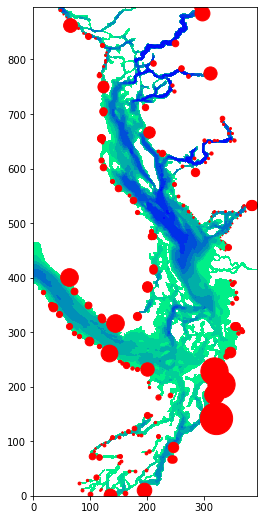

In [17]:
imin, imax = 0, 898
jmin, jmax = 0, 394
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.contourf(bathy.Bathymetry[imin:imax, jmin:jmax], cmap='winter_r')
for i in range(imin, imax):
    for j in range(jmin, jmax):
        flux = runoff[i, j]
        if flux > 0 :
            plt.scatter(j - jmin, i - imin, s=flux*1000, color='r')

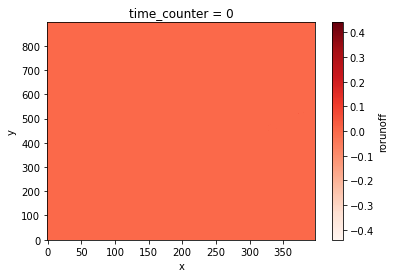

In [19]:
readitin = xr.open_dataset('ncfiles/R202102Dailies_y2015m03d31.nc')
climate = xr.open_dataset('ncfiles/R202101Dailies_y2015m03d31.nc')
fluxarray = readitin.rorunoff[0]
climatearray = climate.rorunoff[0]
(fluxarray - climatearray).plot(cmap='Reds');

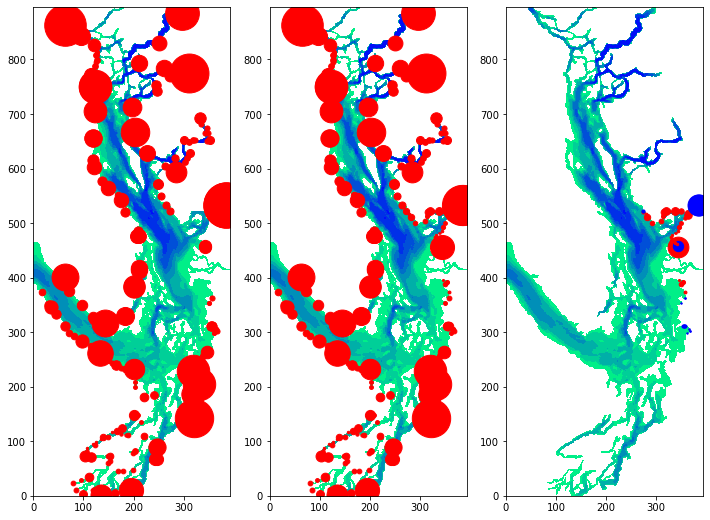

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
for ax in axs:
    ax.contourf(bathy.Bathymetry[imin:imax, jmin:jmax], cmap='winter_r')
for i in range(imin, imax):
    for j in range(jmin, jmax):
        flux = fluxarray[i, j]
        if flux > 0 :
            axs[1].scatter(j - jmin, i - imin, s=flux*1000, color='r')
            axs[0].scatter(j - jmin, i - imin, s=climatearray[i, j]*1000, color='r')
            if flux > climatearray[i, j]:
                axs[2].scatter(j - jmin, i-imin, s=(flux-climatearray[i, j])*1000, color='r')
            else:
                axs[2].scatter(j - jmin, i-imin, s=(climatearray[i, j]-flux)*1000, color='b')
            
readitin.close()
climate.close()
# March 31

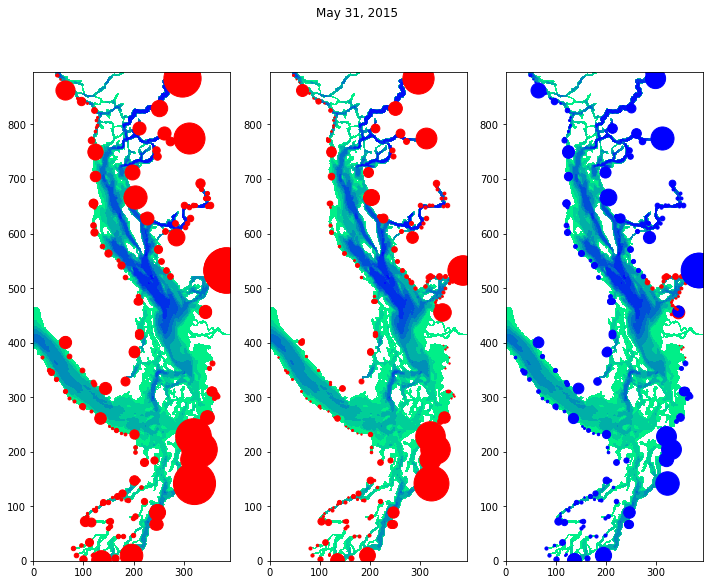

In [22]:
readitin = xr.open_dataset('ncfiles/R202102Dailies_y2016m05d31.nc')
climate = xr.open_dataset('/results/forcing/rivers/R201702DFraCElse_y2016m05d31.nc')
fluxarray = readitin.rorunoff[0]
climatearray = climate.rorunoff[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
fig.suptitle('May 31, 2016')
for ax in axs:
    ax.contourf(bathy.Bathymetry[imin:imax, jmin:jmax], cmap='winter_r')
for i in range(imin, imax):
    for j in range(jmin, jmax):
        flux = fluxarray[i, j]
        if flux > 0 :
            axs[1].scatter(j - jmin, i - imin, s=flux*1000, color='r')
            axs[0].scatter(j - jmin, i - imin, s=climatearray[i, j]*1000, color='r')
            if flux > climatearray[i, j]:
                axs[2].scatter(j - jmin, i-imin, s=(flux-climatearray[i, j])*1000, color='r')
            else:
                axs[2].scatter(j - jmin, i-imin, s=(climatearray[i, j]-flux)*1000, color='b')
            
readitin.close()
climate.close()

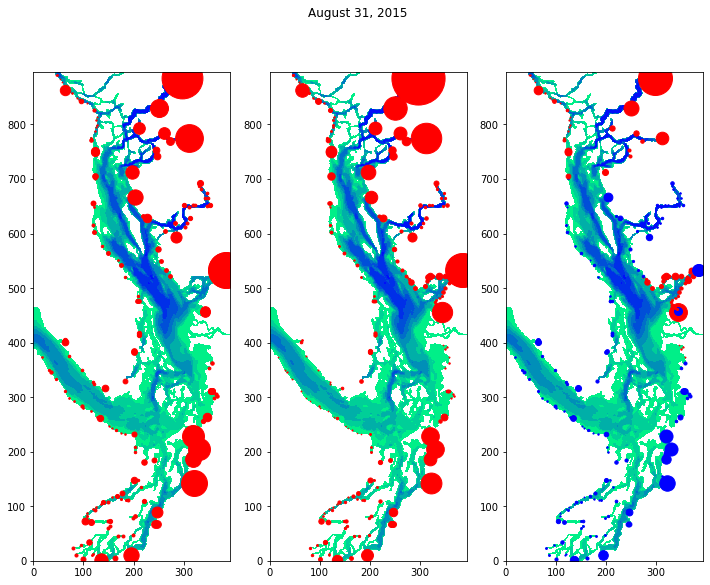

In [23]:
readitin = xr.open_dataset('ncfiles/R202102Dailies_y2016m08d31.nc')
climate = xr.open_dataset('/results/forcing/rivers/R201702DFraCElse_y2016m08d31.nc')
fluxarray = readitin.rorunoff[0]
climatearray = climate.rorunoff[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
fig.suptitle('August 31, 2016')
for ax in axs:
    ax.contourf(bathy.Bathymetry[imin:imax, jmin:jmax], cmap='winter_r')
for i in range(imin, imax):
    for j in range(jmin, jmax):
        flux = fluxarray[i, j]
        if flux > 0 :
            axs[1].scatter(j - jmin, i - imin, s=flux*1000, color='r')
            axs[0].scatter(j - jmin, i - imin, s=climatearray[i, j]*1000, color='r')
            if flux > climatearray[i, j]:
                axs[2].scatter(j - jmin, i-imin, s=(flux-climatearray[i, j])*1000, color='r')
            else:
                axs[2].scatter(j - jmin, i-imin, s=(climatearray[i, j]-flux)*1000, color='b')
            
readitin.close()
climate.close()

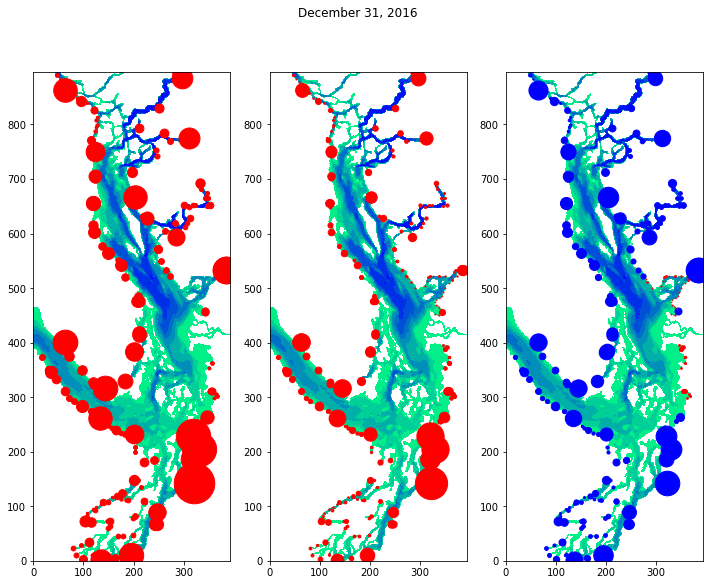

In [25]:
readitin = xr.open_dataset('ncfiles/R202102Dailies_y2016m12d31.nc')
climate = xr.open_dataset('/results/forcing/rivers/R201702DFraCElse_y2016m12d31.nc')
fluxarray = readitin.rorunoff[0]
climatearray = climate.rorunoff[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
fig.suptitle('December 31, 2016')
for ax in axs:
    ax.contourf(bathy.Bathymetry[imin:imax, jmin:jmax], cmap='winter_r')
for i in range(imin, imax):
    for j in range(jmin, jmax):
        flux = fluxarray[i, j]
        if flux > 0 :
            axs[1].scatter(j - jmin, i - imin, s=flux*1000, color='r')
            axs[0].scatter(j - jmin, i - imin, s=climatearray[i, j]*1000, color='r')
            if flux > climatearray[i, j]:
                axs[2].scatter(j - jmin, i-imin, s=(flux-climatearray[i, j])*1000, color='r')
            else:
                axs[2].scatter(j - jmin, i-imin, s=(climatearray[i, j]-flux)*1000, color='b')
            
readitin.close()
climate.close()